# Прогнозирование временных рядов при помощи машинного обучения. Домашнее задание


Будем прогнозировать количество проданного товара в городе Бангалор (Индия)

## Предобработка временного ряда

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
# данные по продажам в Индии в различных городах и штатах
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")

df.date = pd.DatetimeIndex(df.date)

# Отсортируем и добавим date в индекс
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")

In [4]:
# Оставим только целевой ряд (`quantity`)
dfBang = df.loc[df.city == "BANGALORE"].copy()

# Удалим лишние столбцы
ts = dfBang.drop(
    ["market", "month", "year", "state", "city", "priceMin", "priceMax", "priceMod", "date"], axis=1
)

ts.head()

,quantity
date,
2004-01,227832
2004-02,225133
2004-03,221952
2004-04,185150
2004-05,137390


Посмотрим как ведет себя временной ряд

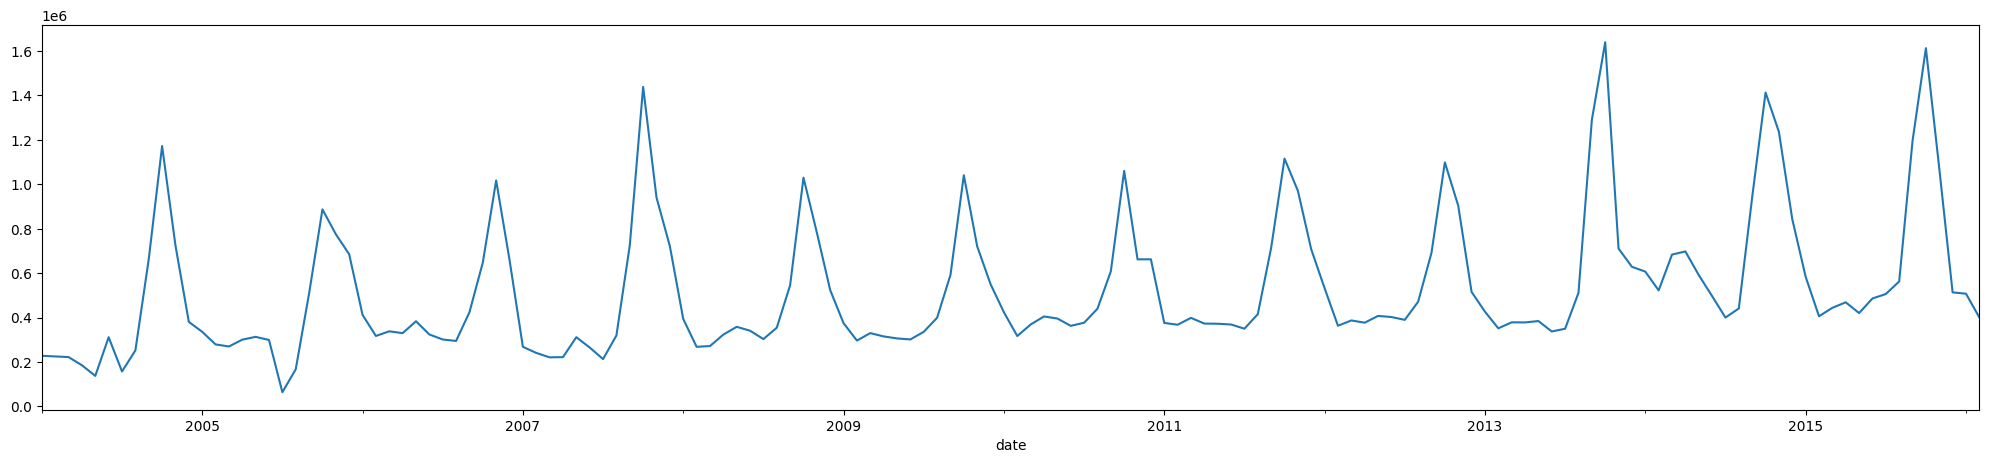

In [5]:
ts.quantity.plot(figsize=(25,5));

## Машинное обучение для прогнозирования временных рядов

## Задание

Извлеките первые 7 лаговых признаков из ряда (лаг на 1, 2 ... 7 месяцев).

Чему равно первое (самое старое) известное значение лага 4 периода назад? Ответ округлите до целого числа.

In [6]:
for i in range (1,8):
    ts[f"lag_{i}"] = ts.quantity.shift(i)
ts[4:5]

,quantity,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2004-05,137390,185150.0,221952.0,225133.0,227832.0,NaN,NaN,NaN


In [8]:
ts = ts.dropna()

### Разбиение на train и test для временных рядов

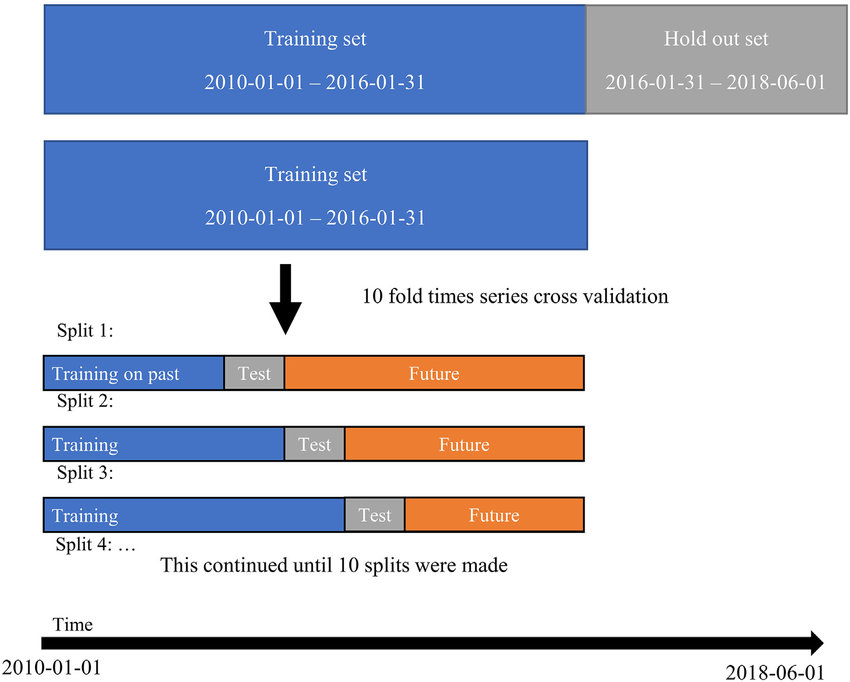

## Задание

Разбейте данные (quantity) на train и test.

train - первые 85% данных

test - следующие 15% данных

Сколько измерений попало в тестовую часть?

In [9]:
split_index = int(0.85*len(ts))

train = ts.iloc[:split_index]
test = ts.iloc[split_index:]

print('Ответ:', test.shape[0])


Ответ: 21


## Задание

Разбейте тренировочные и тестовые данные на матрицы объект-признак `X_train`, `X_test` и векторы с целевой переменной `y_train`, `y_test`.

Чему равно среднее значение `y_test`? Ответ округлите до целого числа

In [10]:
X_train = ts.iloc[:split_index].drop(["quantity"], axis=1)
y_train = ts.iloc[:split_index]["quantity"]
X_test = ts.iloc[split_index:].drop(["quantity"], axis=1)
y_test = ts.iloc[split_index:]["quantity"]
answer = ts.iloc[split_index:]["quantity"].mean()
print ('Ответ:', answer.round())

Ответ: 711637.0


## Прогнозирование временных рядов

Обратите внимание, что в функции мы сами по индексу разбили датасет на обучающую и валидационную выборку для обучения моделей. Мы не можем воспользовать train_test_split, так как нам необходимо сохранять хронологию в деление выборки на части, т.е. случайное сэмплирование наблюдений нам не подойдет, в частности, т.к. мы хотим выучить тренд в данных.

## Задание

Обучите линейную регрессию на тренировочных данных и посчитайте $R^2$ на тесте.

Ответ округлите до сотых.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Text(0.5, 1.0, 'Линейная регрессия\n r2 0.5010248271570561')

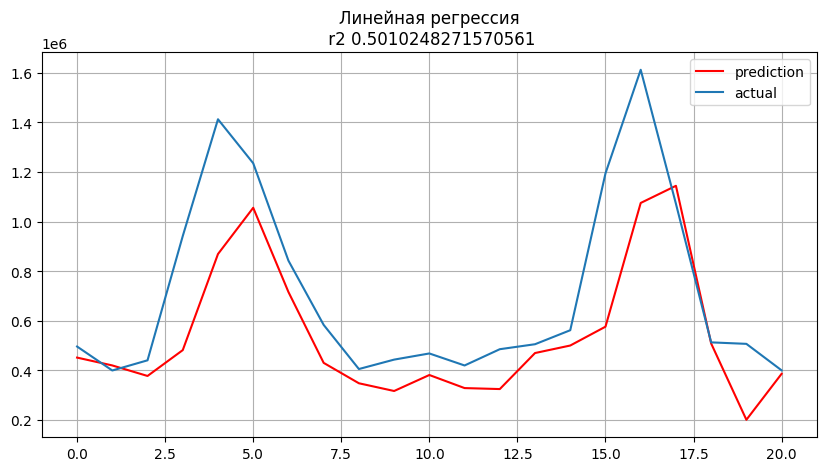

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(preds, "r", label = "prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Линейная регрессия\n r2 {r2_score(y_test, preds )}")

## Агрегированные признаки

Используем функцию, которая возвращает словарь, где ключами являются уникальные категории признака `cat_feature`, а значениями - средние по `real_feature`.

In [13]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

## Задание

Создайте колонку `month`, содержащую месяц (из даты).

Вычислите среднее значение целевой переменной по месяцам (по всем обучающим данным до разбиения на train и test).

В какой месяц года среднее количество проданного товара максимально? В ответе укажите номер месяца.

In [14]:
ts['month']=ts.index.month
ts["month_average"] = list(map(code_mean(ts[:split_index], "month", "quantity").get, ts.month))
ts.sort_values('month_average', ascending = False).head(1)

,quantity,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,month,month_average
date,,,,,,,,,,
2012-10,1098253,691674.0,471034.0,389497.0,402256.0,407188.0,376769.0,386843.0,10,1112561.2


Далее будем использовать функцию preprocess_data.

В функции мы:

1) Разбиваем данные на тренировочную и тестовую части

2) Генерируем лаговые признаки

3) Генерируем агрегированные признаки

In [15]:
ts = dfBang.drop(
    ["market", "month", "year", "state", "city", "priceMin", "priceMax", "priceMod", "date"], axis=1
)

In [19]:
index_cut = int(0.815*len(ts))

In [20]:
def preprocess_data(data, lag_start=1, lag_end=8, index_cut=index_cut):

    data = pd.DataFrame(data.copy())

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['quantity'].shift(i)

    data = data.dropna()

    data["month"] = data.index.month

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    data["month_average"] = list(map(code_mean(data.iloc[:index_cut], "month", "quantity").get, data.month))

    # выкидываем закодированные средними признаки
    data.drop(["month"], axis=1, inplace=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:index_cut].drop(["quantity"], axis=1)
    y_train = data.iloc[:index_cut]["quantity"]
    X_test = data.iloc[index_cut:].drop(["quantity"], axis=1)
    y_test = data.iloc[index_cut:]["quantity"]

    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = preprocess_data(ts)

X_train.shape, X_test.shape


((118, 8), (21, 8))

## Задание

Обучите линейную регрессию на подготовленных тренировочных данных и выведите $R^2$ на тесте.

Ответ округлите до сотых.

Text(0.5, 1.0, 'Линейная регрессия\n r2 0.7439158650185002')

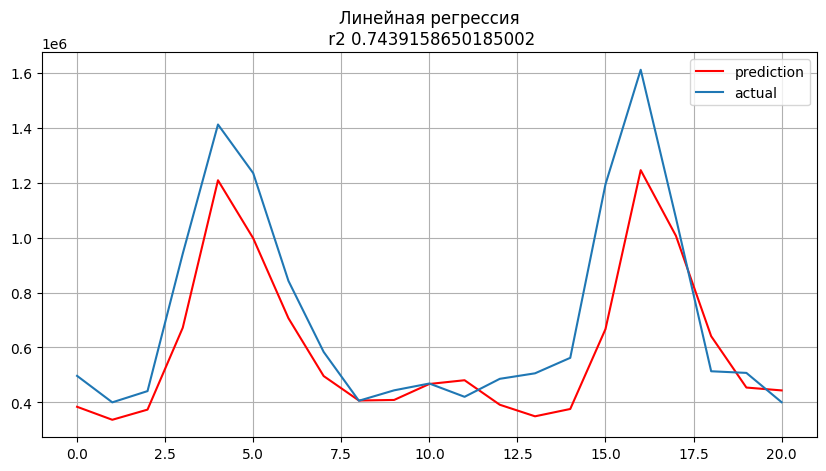

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(preds, "r", label = "prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Линейная регрессия\n r2 {r2_score(y_test, preds )}")

## Задание

Заново разбейте данные на train и test, используя `preprocess_data` с лагами от 1 до 12 не включительно.

Обучите линейную регрессию. Чему теперь равен $R^2$? Ответ округлите до сотых.

In [23]:
def preprocess_data(data, lag_start=1, lag_end=12, index_cut=index_cut):

    data = pd.DataFrame(data.copy())

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['quantity'].shift(i)

    data = data.dropna()

    data["month"] = data.index.month

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    data["month_average"] = list(map(code_mean(data.iloc[:index_cut], "month", "quantity").get, data.month))

    # выкидываем закодированные средними признаки
    data.drop(["month"], axis=1, inplace=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:index_cut].drop(["quantity"], axis=1)
    y_train = data.iloc[:index_cut]["quantity"]
    X_test = data.iloc[index_cut:].drop(["quantity"], axis=1)
    y_test = data.iloc[index_cut:]["quantity"]

    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = preprocess_data(ts)

X_train.shape, X_test.shape


((118, 12), (17, 12))

Text(0.5, 1.0, 'Линейная регрессия\n r2 0.8591152640658721')

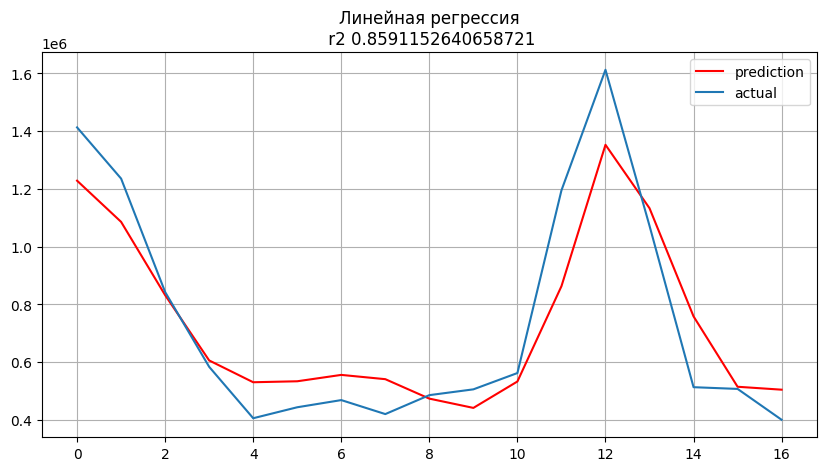

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(preds, "r", label = "prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Линейная регрессия\n r2 {r2_score(y_test, preds )}")

## Задание

Обучите CatBoostRegressor с гиперпараметрами по умолчанию на тех же данных, что и линейную регрессию из предыдущего задания. Чему теперь равен $R^2$? Ответ округлите до десятых.

Learning rate set to 0.02921
0:	learn: 265587.3165548	total: 138ms	remaining: 2m 18s
1:	learn: 261071.8931381	total: 139ms	remaining: 1m 9s
2:	learn: 257368.8273561	total: 140ms	remaining: 46.6s
3:	learn: 253479.6090882	total: 141ms	remaining: 35.1s
4:	learn: 249768.1752293	total: 142ms	remaining: 28.2s
5:	learn: 246291.4309278	total: 142ms	remaining: 23.6s
6:	learn: 243507.5633421	total: 143ms	remaining: 20.3s
7:	learn: 240550.1037802	total: 144ms	remaining: 17.8s
8:	learn: 237176.9677208	total: 144ms	remaining: 15.9s
9:	learn: 233132.0312718	total: 145ms	remaining: 14.4s
10:	learn: 230177.1660152	total: 146ms	remaining: 13.1s
11:	learn: 226849.9185607	total: 147ms	remaining: 12.1s
12:	learn: 223704.5036253	total: 148ms	remaining: 11.3s
13:	learn: 221180.3745426	total: 149ms	remaining: 10.5s
14:	learn: 218267.8346022	total: 150ms	remaining: 9.84s
15:	learn: 214548.8285753	total: 151ms	remaining: 9.26s
16:	learn: 211767.5314004	total: 151ms	remaining: 8.75s
17:	learn: 208769.8957198	to

Text(0.5, 1.0, 'Линейная регрессия\n r2 0.6115594538881034')

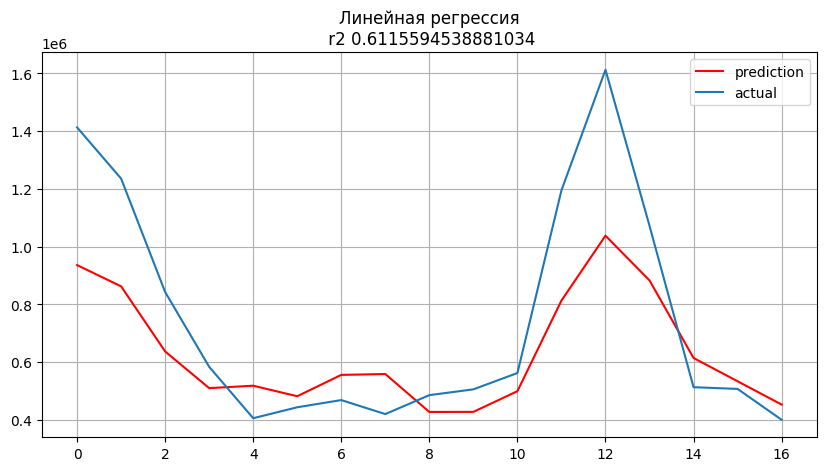

In [26]:
from catboost import CatBoostRegressor
cb = CatBoostRegressor()
cb.fit(X_train, y_train)

preds = cb.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(preds, "r", label = "prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Линейная регрессия\n r2 {r2_score(y_test, preds )}")
